In [ ]:
pip install torch torchvision

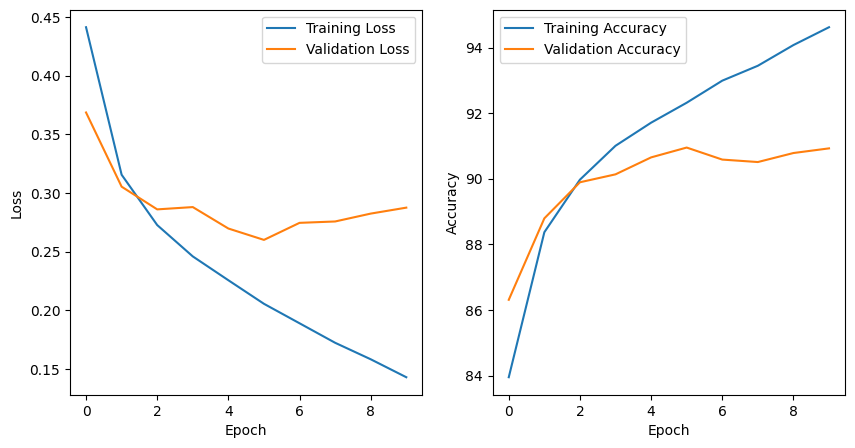

Final accuracy on the test dataset: 90.41%


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define transforms for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load FashionMNIST dataset
full_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                  download=True, transform=transform)

# Splitting the full training set into a balanced train and validation set
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = torch.utils.data.random_split(full_trainset, [train_size, val_size])

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                           download=True, transform=transform)

# Ensure balanced training, validation, and test sets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Define the ResNet18 architecture with modifications
class ModifiedResNet18(nn.Module):
    def __init__(self):
        super(ModifiedResNet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=False)
        # Adjust the first convolutional layer to handle single-channel input
        self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet18.avgpool = nn.AdaptiveAvgPool2d(1)  # Global Average Pooling
        self.resnet18.fc = nn.Linear(512, 10)   # FashionMNIST has 10 classes

    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)

        x = self.resnet18.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.resnet18.fc(x)
        return x

# Initialize the model, loss function, and optimizer
model = ModifiedResNet18()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy.append(100 * correct_train / total_train)
    train_losses.append(running_loss / len(trainloader))

    # Validation of the model
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy.append(100 * correct_val / total_val)
    val_losses.append(running_loss / len(valloader))

    model.train()

# Final evaluation on the test dataset
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test

# Plotting accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Final evaluation on the test dataset
print(f'Final accuracy on the test dataset: {test_accuracy}%')

#separation index and accuracy

In [ ]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy
# Function to calculate the first-order separation index
def calculate_separation_index(labels, num_classes):
    class_counts = [0] * num_classes
    total_samples = len(labels)

    for label in labels:
        class_counts[label] += 1

    separation_index = 0
    for count in class_counts:
        separation_index += (count / total_samples) * (1 - count / total_samples)
    return separation_index

# Function to extract activations from the last layer before the classification
def get_last_layer_activations(data_loader, model):
    activations = []
    labels_list = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            # Assuming the last layer before the classification in your model
            activations.append(outputs.clone().detach())  # Adjust based on your model structure
            labels_list.append(labels)

    return torch.cat(activations), torch.cat(labels_list)

# Get activations and labels for a balanced subset of the training data
balanced_train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
train_last_layer_activations, train_labels = get_last_layer_activations(balanced_train_loader, model)

# Calculate the separation index and accuracy for the training data
num_classes = 10  # FashionMNIST has 10 classes
separation_index_train = calculate_separation_index(train_labels, num_classes)
train_accuracy = calculate_accuracy(train_last_layer_activations, train_labels)

print(f"Separation Index for the training data: {separation_index_train}")
print(f"Accuracy for the training data: {train_accuracy * 100}%")

# Evaluate on the test dataset
test_last_layer_activations, test_labels = get_last_layer_activations(testloader, model)
separation_index_test = calculate_separation_index(test_labels, num_classes)
test_accuracy = calculate_accuracy(test_last_layer_activations, test_labels)

print(f"Separation Index for the test data: {separation_index_test}")
print(f"Accuracy for the test data: {test_accuracy * 100}%")

Separation Index for the training data: 0.8999971684027775
Accuracy for the training data: 90.97916666666667%
Separation Index for the test data: 0.8999999999999999
Accuracy for the test data: 87.07000000000001%


#Anti-separation index

In [ ]:
def calculate_separation_index(labels, num_classes):
    class_counts = [0] * num_classes
    total_samples = len(labels)

    for label in labels:
        class_counts[label] += 1

    separation_index = 0
    for count in class_counts:
        separation_index += (count / total_samples) * (1 - count / total_samples)
    return separation_index

# Function to extract activations from the last layer before the classification
def get_last_layer_activations(data_loader, model):
    activations = []
    labels_list = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            # Assuming the last layer before the classification in your model
            activations.append(outputs.clone().detach())  # Adjust based on your model structure
            labels_list.append(labels)

    return torch.cat(activations), torch.cat(labels_list)

# Get activations and labels for a balanced subset of the training data
balanced_train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
train_last_layer_activations, train_labels = get_last_layer_activations(balanced_train_loader, model)

# Calculate the separation index for the last layer activations
num_classes = 10  # FashionMNIST has 10 classes
Anti_separation_index_train = calculate_separation_index(train_labels, num_classes)

# Evaluate on the test dataset
test_last_layer_activations, test_labels = get_last_layer_activations(testloader, model)
Anti_separation_index_test = calculate_separation_index(test_labels, num_classes)

print(f"Anti Separation Index (2) for the test data: {Anti_separation_index_test}")
print(f"Anti Separation Index (2) for the training data: {Anti_separation_index_train}")

Anti Separation Index (2) for the test data: 0.0490614698
Anti Separation Index (2) for the training data: 0.048141579861


#center based separation index

In [ ]:
import torch
import numpy as np

# Function to calculate the Center-based Separation Index (CSI)
def calculate_center_based_separation_index(data, labels, num_classes):
    # Convert torch tensor to numpy array
    data = data.numpy()

    # Number of data points
    m = len(labels)

    # Initialize class centroids and counts
    class_centroids = np.zeros((num_classes, data.shape[1]))
    class_counts = np.zeros(num_classes)

    # Calculate class centroids
    for i, label in enumerate(labels):
        class_centroids[label] += data[i]
        class_counts[label] += 1

    # Calculate means (centroids) for each class
    for c in range(num_classes):
        class_centroids[c] /= class_counts[c]

    # Calculate distance matrix from data points to class centroids
    distances = np.zeros((m, num_classes))
    for i in range(m):
        for c in range(num_classes):
            distances[i][c] = np.linalg.norm(data[i] - class_centroids[c])

    # Find the closest centroid index for each data point
    closest_centroid_index = np.argmin(distances, axis=1)

    # Calculate CSI
    CSI = 0
    for i in range(m):
        CSI += np.linalg.norm(data[i] - class_centroids[closest_centroid_index[i]])

    CSI /= m

    return CSI

# Assuming 'num_classes' is defined
num_classes = 10  # FashionMNIST has 10 classes

# Calculate center-based separation index for training and test data
center_based_separation_train = calculate_center_based_separation_index(train_last_layer_activations, train_labels, num_classes)
center_based_separation_test = calculate_center_based_separation_index(test_last_layer_activations, test_labels, num_classes)

print(f"Center-Based Separation Index for the training data: {center_based_separation_train}")
print(f"Center-Based Separation Index for the test data: {center_based_separation_test}")

Center-Based Separation Index for the training data: 0.8050181875316437
Center-Based Separation Index for the test data: 0.8036544533079993


#High ordr Soft SI

In [ ]:
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Function to calculate the High Order Separation Index (SIr)
def calculate_high_order_separation_index(data, labels, num_classes, r):
    # Convert torch tensor to numpy array
    data = data.numpy()

    # Number of data points
    m = len(labels)

    # Initialize SIr
    SIr = 0

    # Calculate nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=r+1, algorithm='auto').fit(data)
    distances, indices = nbrs.kneighbors(data)

    for i in range(m):
        label_i = labels[i]
        same_label_count = 0

        for j in range(1, r+1):  # Skip the first element (itself)
            neighbor_index = indices[i][j]
            if labels[neighbor_index] == label_i:
                same_label_count += 1

        if same_label_count == r:  # All 'r' nearest neighbors have the same label
            SIr += 1

    SIr /= m  # Normalize by the total number of data points

    return SIr

# Assuming 'num_classes' and 'r' (order of SIr) are defined
num_classes = 10  # FashionMNIST has 10 classes
r = 3  # Order of SIr

# Calculate high order separation index for training and test data
high_order_separation_train = calculate_high_order_separation_index(train_last_layer_activations, train_labels, num_classes, r)
high_order_separation_test = calculate_high_order_separation_index(test_last_layer_activations, test_labels, num_classes, r)

print(f"High Order Soft Separation Index (SIr={r}) for the training data: {high_order_separation_train}")
print(f"High Order Soft Separation Index (SIr={r}) for the test data: {high_order_separation_test}")

High Order Soft Separation Index (SIr=3) for the training data: 0.7878541666666666
High Order Soft Separation Index (SIr=3) for the test data: 0.7209


In [ ]:
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Function to calculate the High Order Separation Index (SIr)
def calculate_high_order_separation_index(data, labels, num_classes, r):
    # Convert torch tensor to numpy array
    data = data.numpy()

    # Number of data points
    m = len(labels)

    # Initialize SIr
    SIr = 0

    # Calculate nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=r+1, algorithm='auto').fit(data)
    distances, indices = nbrs.kneighbors(data)

    for i in range(m):
        label_i = labels[i]
        same_label_count = 0

        for j in range(1, r+1):  # Skip the first element (itself)
            neighbor_index = indices[i][j]
            if labels[neighbor_index] == label_i:
                same_label_count += 1

        if same_label_count == r:  # All 'r' nearest neighbors have the same label
            SIr += 1

    SIr /= m  # Normalize by the total number of data points

    return SIr

# Assuming 'num_classes' and 'r' (order of SIr) are defined
num_classes = 10  # FashionMNIST has 10 classes
r = 2  # Order of SIr

# Calculate high order separation index for training and test data
high_order_separation_train = calculate_high_order_separation_index(train_last_layer_activations, train_labels, num_classes, r)
high_order_separation_test = calculate_high_order_separation_index(test_last_layer_activations, test_labels, num_classes, r)

print(f"High Order Soft Separation Index (SIr={r}) for the training data: {high_order_separation_train}")
print(f"High Order Soft Separation Index (SIr={r}) for the test data: {high_order_separation_test}")

High Order Soft Separation Index (SIr=2) for the training data: 0.8300207851428
High Order Soft Separation Index (SIr=2) for the test data: 0.8184622323519


#High order SI

In [ ]:
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Function to calculate the High Order Soft Separation Index (SIsoft)
def calculate_high_order_soft_separation_index(data, labels, num_classes, r):
    # Convert torch tensor to numpy array
    data = data.numpy()

    # Number of data points
    m = len(labels)

    # Initialize SIsoft
    SIsoft = 0

    # Calculate nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=r+1, algorithm='auto').fit(data)
    distances, indices = nbrs.kneighbors(data)

    for i in range(m):
        label_i = labels[i]
        dissimilarity_sum = 0

        for j in range(1, r+1):  # Skip the first element (itself)
            neighbor_index = indices[i][j]
            if labels[neighbor_index] != label_i:
                dissimilarity_sum += 1  # Increase dissimilarity for different labels

        soft_distance = dissimilarity_sum / r
        SIsoft += soft_distance

    SIsoft /= m  # Normalize by the total number of data points

    return SIsoft

# Assuming 'num_classes' and 'r' (order of SIsoft) are defined
num_classes = 10  # FashionMNIST has 10 classes
r = 3  # Order of SIsoft

# Calculate high order soft separation index for training and test data
high_order_soft_separation_train = calculate_high_order_soft_separation_index(train_last_layer_activations, train_labels, num_classes, r)
high_order_soft_separation_test = calculate_high_order_soft_separation_index(test_last_layer_activations, test_labels, num_classes, r)

print(f"High Order Separation Index (SIr={r}) for the training data: {high_order_soft_separation_train}")
print(f"High Order Separation Index (SIr={r})) for the test data: {high_order_soft_separation_test}")

High Order Separation Index (SIr=3) for the training data: 0.3782953181
High Order Separation Index (SIr=3) for the test data: 0.3461704682


In [ ]:
import torch
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Function to calculate the High Order Soft Separation Index (SIsoft)
def calculate_high_order_soft_separation_index(data, labels, num_classes, r):
    # Convert torch tensor to numpy array
    data = data.numpy()

    # Number of data points
    m = len(labels)

    # Initialize SIsoft
    SIsoft = 0

    # Calculate nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=r+1, algorithm='auto').fit(data)
    distances, indices = nbrs.kneighbors(data)

    for i in range(m):
        label_i = labels[i]
        dissimilarity_sum = 0

        for j in range(1, r+1):  # Skip the first element (itself)
            neighbor_index = indices[i][j]
            if labels[neighbor_index] != label_i:
                dissimilarity_sum += 1  # Increase dissimilarity for different labels

        soft_distance = dissimilarity_sum / r
        SIsoft += soft_distance

    SIsoft /= m  # Normalize by the total number of data points

    return SIsoft

# Assuming 'num_classes' and 'r' (order of SIsoft) are defined
num_classes = 10  # FashionMNIST has 10 classes
r = 2  # Order of SIsoft

# Calculate high order soft separation index for training and test data
high_order_soft_separation_train = calculate_high_order_soft_separation_index(train_last_layer_activations, train_labels, num_classes, r)
high_order_soft_separation_test = calculate_high_order_soft_separation_index(test_last_layer_activations, test_labels, num_classes, r)

print(f"High Order Separation Index (SIr={r}) for the training data: {high_order_soft_separation_train}")
print(f"High Order Separation Index (SIr={r})) for the test data: {high_order_soft_separation_test}")

High Order Separation Index (SIr=2) for the training data: 0.60579831935
High Order Separation Index (SIr=2) for the test data: 0.562016806675
